In [127]:
print('Arabic Font Classification Project!!')

Arabic Font Classification Project!!


# Classification Methods
In this lab, it is required to identify between different hand-drawn shapes; such as rectangles, circles, triangles, ellipses, polygons, etc.

We will start our first lab in this course by understanding the main pipeline of any machine learning project:

**Important Note:** **Read all the code and fill the required functions in the 'utils' notebook as you go.**

In [128]:
#Always make all imports in the first cell of the notebook, run them all once.
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from __future__ import division
import numpy as np
from scipy.signal import convolve2d
from sklearn import svm ,metrics
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.utils import shuffle
import pickle

# for NN:
import keras
from keras.models import Sequential
from keras.layers import Dense


%matplotlib inline

# A Machine Learning (ML) project is divided into many stages:

## 1. Gathering Data (Data Acquisition):

The first real step of machine learning is gathering data. This step is very important because the **quality and quantity** of data that you gather will directly determine how good your predictive model can be.

We define placeholders for the data as follows: 
* **x_train:** This represents the images in the training set. 
* **y_train:** This represents the labels of the images in the training set.  

In [157]:
x_train = []
y_train = []
x_test = []
y_test = []
styles = []

In [158]:
# load styles names:
with open('ACdata_base/names.txt') as file:
    lines = file.readlines()
    styles = [line.rstrip()[4:] for line in lines] # ignoring number at first of each style (first 4 chars)
print(styles)


['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']


In [159]:
## load styles images:
x=[]
y=[]
for i in range(1, len(styles)+1):
    for filename in sorted(glob.glob('ACdata_base/'+str(i)+'/*.jpg')):
        img = cv2.imread(filename) ## cv2.imread reads images in RGB format
        x_train.append(img)
        y_train.append(i-1)
        # x.append(img)
        # y.append(i-1)

# for i in range(1, len(styles)+1):
#     for filename in sorted(glob.glob('ACdata_base_test/'+str(i)+'/*.jpg')):
#         img = cv2.imread(filename) ## cv2.imread reads images in RGB format
#         x_test.append(img)
#         y_test.append(i-1)

In [160]:
# A good practice is to convert lists into numpy arrays. When it comes to actual machine learning algorithms, 
# it is better to work with NumPy arrays.
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
#x_train = x_train.reshape(-1,1)
#y_train = y_train.reshape(-1,1)

print ("The size of the training set is: ", x_train.shape)

# We have a lot of images of different arabic styles, where each image is an RGB image of dimensions 200x200x3. 
# (images, height, width, channels)

print ("The size of the labels of the training set is: ", y_train.shape)
print (y_train)

The size of the training set is:  (1685,)
The size of the labels of the training set is:  (1685,)
[0 0 0 ... 8 8 8]


C:\Users\teray\AppData\Local\Temp/ipykernel_9468/2515832367.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.asarray(x_train)


We will now visualize this dataset. 

**Note: You can run the following cell multiple times to view different shapes in the dataset as well as the ground-truth value associated with this training image.**

The ground-truth value of this image is:  rekaa


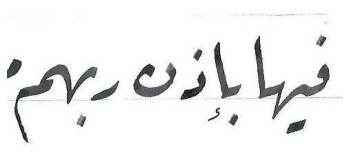

In [161]:
# Generate a random index from 0 to 18 inclusive. 
random_index = np.random.randint(0,18)

# Plot the image.
plt.imshow(x_train[570])
plt.axis("off")

print("The ground-truth value of this image is: " , styles[y_train[570]])

- - -
# 2. Data Preprocessing:

The second stage is to convert the raw data into a clean data set. In other words, whenever the data is gathered from different sources it is collected in raw format which is not feasible for the analysis. We need to prepare it to be suitable for our problem.

In this step, we will apply preprocessing to the images in **x_train** as follows: 
   1. Convert RGB images to grayscale images. Use the function **cv2.cvtColor** 
   2. Remove noise in images by blurring (averaging). Use the function **cv2.blur**
   3. Applying a binary threshold on the image pixels. Use the function **cv2.threshold**. The pixels having intensity less than this threshold should be considered black pixels, and white otherwise. 

In [162]:
def preprocess(img):
    # Preprocess the given image img.
    #-----------------------------------------------------------------------------------------------
    # Convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #-----------------------------------------------------------------------------------------------
    #Convert the grayscale image to a binary image. Apply a threshold using Otsu's method on the blurred image.
    # get the threshold of the image using Otsu's method
    thresh = threshold_otsu(gray)
    thresholded_img = gray > thresh
    #_, thresholded_img = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    #-----------------------------------------------------------------------------------------------
    return thresholded_img

In [163]:
# We will apply the function you implemented for each image in the training set (x_train) 
# and add the pre-processed images to a new list (x_train_preprocessed.)
x_train_preprocessed = []
for i in range(x_train.shape[0]):
    preprocessed_img = preprocess(x_train[i])
    x_train_preprocessed.append(preprocessed_img)


In [164]:
x_train_preprocessed = np.asarray(x_train_preprocessed)

shape = x_train_preprocessed.shape 

C:\Users\teray\AppData\Local\Temp/ipykernel_9468/2423651716.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train_preprocessed = np.asarray(x_train_preprocessed)


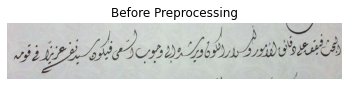

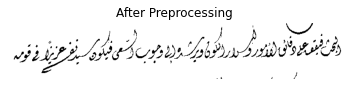

In [165]:
# Let's visualize what happened after preprocessing 

# Generate a random index from 0 to 18 inclusive. 
random_index = np.random.randint(0,18)

# Plot the image before preprocessing.
plt.imshow(x_train[random_index],cmap='gray')
plt.axis("off")
plt.title("Before Preprocessing")
plt.show()

# Plot the image after preprocessing.
plt.imshow(x_train_preprocessed[random_index],cmap='gray')
plt.axis("off")
plt.title("After Preprocessing")
plt.show()


In [166]:
# We do not need the original x_train anymore. We will work on x_train_preprocessed from now on. 
x_train = x_train_preprocessed


- - -
# 3. Feature Extraction: 

Now that we have clean and preprocessed data, we can use it to solve our classification problem.

This step could be either:
    
* **Feature Engineering:** transformation of raw data into features suitable for modeling.

* **Feature Transformation:** transformation of data to improve the accuracy of the algorithm.

* **Feature Selection:** removing unnecessary features.
    
The process of feature extraction in our problem can have many designs:

* One design is to extract the number of black pixels compared to the number of white pixels in each image and use this feature to differentiate between different shapes. (Is this a powerful feature?) Can you think of other features?


A more powerful set of features can be obtained by computing the convex hull of these shapes, and compare the area of this convex hull with the minimum enclosing circle, minimum enclosing rectangle and minimum enclosing triangle bounding that figure.


In the example above, the ratio between the areas of the convex hull (traingular figure) to the area of the bounding triangle will be maximum, and relatively smaller for the bounding rectangle and circle respectively. 

On the other hand, if the given shape was a circle, then the ratio between the areas of the shape to the bounding circle will be maximum and smaller for the bounding rectangle and triangle. 

Therefore, each image will be represented with a feature vector in three dimensions **(x, y and z)** where each component represents the ratio between the area of the figure to the area of the bounding rectangle, circle and triangle respectively.

**The images in the example above can be represented as a feature vector (0.67, 0.58, 0.92)**

We will now implement all functions needed for feature extraction.

In [167]:
# LPQ "Local Phase Quantization" Feature Extraction:
# Blurring insensitive
def lpq(img,winSize=5,freqestim=1,mode='nh'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    #print(LPQdesc)
    return LPQdesc

We finally populate the array **training_features** with the extracted features from each image using the functions you implemented earlier. 

## Visualize the Features
A very useful step here is to visualize your features, see how they separate different classes from one another, and how they group data points from the same class closer together.

In [168]:
features = [lpq(x,winSize=5) for x in x_train]
features= np.array(features)

- - -
# 4. ML Model: 
It’s time to feed the crafted features to the classification algorithm that is going to classify or predict the class of unknown or newly unseen data (called testing data). The process of choosing which classification algorithm will yield the best results is not an easy one. It is often subject to many iterations of tuning parameters and features.

In this lab, we will apply three classification algorithms and compare their results:
1. **SVM.**
2. **Radnom Forest.**
3. **K-Nearest Neighbour Classifier.**
3. **Neural Network as a Classifier.**


In [169]:
#SVM CLASSIFIER

# average setting, one of [None, 'micro', 'macro', 'weighted'].
def svmCLF(feats,y_lbl,test_x,test_y):
    clf = svm.SVC(kernel='poly',degree=3,C=500,gamma=7) 
    print(feats.shape)
    clf.fit(feats, y_lbl)
    y_preds = clf.predict(test_x)
        
    ascore = metrics.accuracy_score(test_y, y_preds)
    pscore = metrics.precision_score(test_y, y_preds,average='weighted')
    rscore = metrics.recall_score(test_y, y_preds,average='weighted')
    fscore = metrics.f1_score(test_y, y_preds,average='weighted')
    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore,clf
#svmCLF(features,y_train,x_test,y_test)


In [170]:
# KNN CLASSIFIER
def KNNCLF(feats,y_lbl,test_x,test_y):

    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(feats, y_lbl)
    y_predk = clf.predict(test_x)
    ascore = metrics.accuracy_score(test_y, y_predk)
    pscore = metrics.precision_score(test_y, y_predk,average='weighted')
    rscore = metrics.recall_score(test_y, y_predk,average='weighted')
    fscore = metrics.f1_score(test_y, y_predk,average='weighted')
    
    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore,clf
# KNNCLF(features,y_train,x_test,y_test)

In [186]:
# Random Forest Tree CLASSIFIER

# average setting, one of [None, 'micro', 'macro', 'weighted'].
def RFCLF(feats,y_lbl,test_x,test_y):
    clf = RandomForestClassifier(random_state=42, n_estimators=500,)
    print(feats.shape)
    clf.fit(feats, y_lbl)
    
    y_predr = clf.predict(test_x)

    ascore = metrics.accuracy_score(test_y, y_predr)
    pscore = metrics.precision_score(test_y, y_predr,average='weighted')
    rscore = metrics.recall_score(test_y, y_predr,average='weighted')
    fscore = metrics.f1_score(test_y, y_predr,average='weighted')

    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore,clf

# RFCLF(features,y_train,x_test,y_test)

In [187]:
#voting classifier 
def VotingCLF(feats,y_lbl,test_x,test_y):
    clf_rf = RandomForestClassifier(max_depth=13, random_state=3,n_estimators=500)
    clf_svm = svm.SVC(kernel='poly',degree=2,C=500,probability=True)
    print(feats.shape)
    # Soft takes max of probabilities
    # Hard takes max of votings(majority)
    clf_voting = VotingClassifier(estimators=[('svm', clf_svm),('rf', clf_rf)], voting='hard')

    clf_voting.fit(feats, y_lbl)
    
    y_predr = clf_voting.predict(test_x)

    ascore = metrics.accuracy_score(test_y, y_predr)
    pscore = metrics.precision_score(test_y, y_predr,average='weighted')
    rscore = metrics.recall_score(test_y, y_predr,average='weighted')
    fscore = metrics.f1_score(test_y, y_predr,average='weighted')

    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore,clf_voting

In [188]:
# Neural network as a Classifier:

def NeuralCLF(feats,y_lbl,test_x,test_y):
    model = Sequential()
    model.add(Dense(16, input_dim=len(feats[0]), activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    y_lbl=np.asarray(y_lbl).astype(np.float32)
    feats = np.asarray(feats).astype(np.float32)
    history = model.fit(feats, y_lbl, epochs=1000, batch_size=255,verbose=0)

    y_prednn = model.predict(test_x)
    y_prednn_labels = np.argmax(y_prednn,axis=1)
    ascore = metrics.accuracy_score(test_y, y_prednn_labels)
    pscore = metrics.precision_score(test_y, y_prednn_labels,average='weighted')
    rscore = metrics.recall_score(test_y, y_prednn_labels,average='weighted')
    fscore = metrics.f1_score(test_y, y_prednn_labels,average='weighted')

    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore,model

In [189]:
# Fitting each classifiers for preparing it to be dumped into pickle
def RF_fit(feats,y_lbl):
    clf = RandomForestClassifier(random_state=42, n_estimators=500,)
    clf.fit(feats, y_lbl)
    return clf

def svmCLF_fit(feats,y_lbl):
    clf = svm.SVC(kernel='poly',degree=3,C=500,gamma=7) 
    print(feats.shape)
    clf.fit(feats, y_lbl)
    return clf

def KNNCLF_fit(feats,y_lbl):
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(feats, y_lbl)
    return clf
def VotingCLF_fit(feats,y_lbl):
    clf_rf = RandomForestClassifier(max_depth=13, random_state=3,n_estimators=500)
    clf_svm = svm.SVC(kernel='poly',degree=2,C=500,probability=True)
    print(feats.shape)

    clf_voting = VotingClassifier(estimators=[('svm', clf_svm),('rf', clf_rf)], voting='hard')

    clf_voting.fit(feats, y_lbl)
    return clf_voting

def NeuralCLF_fit(feats,y_lbl):
    model = Sequential()
    model.add(Dense(16, input_dim=len(feats[0]), activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    y_lbl=np.asarray(y_lbl).astype(np.float32)
    feats = np.asarray(feats).astype(np.float32)
    history = model.fit(feats, y_lbl, epochs=1000, batch_size=255,verbose=0)
    return model

- - -
# 5. Cross Validation: 
We will use K-fold for cross validation since our data is limited
divindg our data in to k arrays
Training k-1 arrays 
Testing on 1 array

Repeat k permutations on our data set

### Computing Means:
We check for each classifiers' `mean` to check for the best accuracies
classfieirs:
-   SVM
-   RF
-   KNN
-   Neural Network

In [175]:
# Our k-fold returns batches of random folds
def KFold(K,x_train,y_train,seed=0):
    fold_size = round(len(x_train)/K)
    
    x_fold = []# np.zeros((fold_size,1))
    y_fold = []#np.zeros((fold_size,1))
    #random.shuffle(x_train)
    
    x_shuff, y_shuff = shuffle(x_train, y_train, random_state=seed)

    for j in range(K): #10 times
        tempx = []
        tempy = []
        for i in range(j*fold_size,fold_size*(j+1)):
            tempx.append(x_shuff[i])
            tempy.append(y_shuff[i])
        y_fold.append(tempy)
        x_fold.append(tempx)
        print(len(tempx))

        
    # y_fold = np.array(y_fold)
    # x_fold = np.array(x_fold)

    return x_fold,y_fold

# xf,yf = KFold(10,x,y)
# print(xf.shape)


    #random.shuffle(array)

In [176]:
x_fold,y_fold = KFold(10,features,y_train,2)

x_train_f=[]
y_train_f=[]
y_train_nn_f=[]
x_test =[]
y_test = []
for index,_ in enumerate(x_fold): #assiging 10[168]
    if(i==index):
        x_test = x_fold[index]
        y_test = y_fold[index]
    else:
        x_train_f.extend(x_fold[index])
        y_train_f.extend(y_fold[index])
#convert y_train to y_train_nn for NN
for fold_ele in y_train_f:
    ynn = np.zeros(len(styles),dtype='float32')
    ynn[fold_ele] = 1.0
    y_train_nn_f.append(ynn)
x_train_f=np.array(x_train_f)
y_train_f=np.array(y_train_f)
y_train_nn_f=np.array(y_train_nn_f)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(y_train_f.shape)
print(y_train_nn_f.shape)
#NN_score,pn,rn,fn = NeuralCLF(x_train_f,y_train_nn_f,x_test,y_test)

168
168
168
168
168
168
168
168
168
168
(1680,)
(1680, 9)


In [196]:
# x and y passed by k-fold 10 since it's recommended
# Trying it out on svm first
## svm-> x_fold 0-8 x_test=x_fold[9]
def Kprocessing(k,x_fold,y_fold):
    svm_Scores=[]
    KNN_scores=[]
    Voting_scores=[]
    RF_scores= []
    NN_scores= []
    for i in range(k): #loop 10 times
        x_train_f=[]
        y_train_f=[]
        y_train_nn_f=[]
        x_test =[]
        y_test = []
        for index,_ in enumerate(x_fold): #assiging 10[168]
            if(i==index):
                x_test = x_fold[index]
                y_test = y_fold[index]
            else:
                x_train_f.extend(x_fold[index])
                y_train_f.extend(y_fold[index])
        #convert y_train to y_train_nn for NN
        for fold_ele in y_train_f:
            ynn = np.zeros(len(styles),dtype='float32')
            ynn[fold_ele] = 1.0
            y_train_nn_f.append(ynn)
        x_train_f=np.array(x_train_f)
        y_train_f=np.array(y_train_f)
        y_train_nn_f=np.array(y_train_nn_f)
        x_test = np.array(x_test)
        y_test = np.array(y_test)

        # Get scores for each classifiers aprf
        svm_score,ps,rs,fs,svm_clf = svmCLF(x_train_f,y_train_f,x_test,y_test)
        KNN_score,pk,rk,fk,KNN_clf = KNNCLF(x_train_f,y_train_f,x_test,y_test)
        Voting_score,pv,rv,fv,Voting_clf = VotingCLF(x_train_f,y_train_f,x_test,y_test)
        RF_score,pr,rr,fr,RF_clf = RFCLF(x_train_f,y_train_f,x_test,y_test)
        NN_score,pn,rn,fn,NN_model = NeuralCLF(x_train_f,y_train_nn_f,x_test,y_test)



        # appending scores
        svm_Scores.append([svm_score,ps,rs,fs])
        KNN_scores.append([KNN_score,pk,rk,fk])
        Voting_scores.append([Voting_score,pv,rv,fv])
        RF_scores.append([RF_score,pr,rr,fr])
        NN_scores.append([NN_score,pn,rn,fn])

        
        
    # converting to np arrays
    svm_Scores=np.array(svm_Scores)
    KNN_scores=np.array(KNN_scores)
    Voting_scores=np.array(Voting_scores)
    RF_scores=np.array(RF_scores)
    NN_scores=np.array(NN_scores)

    # computing mean accuracies
    svm_meana = np.mean(svm_Scores[:,0])
    KNN_meana = np.mean(KNN_scores[:,0])
    Voting_meana = np.mean(Voting_scores[:,0])
    RF_meana = np.mean(RF_scores[:,0])
    NN_meana = np.mean(NN_scores[:,0])

    # computing mean precision
    svm_meanp = np.mean(svm_Scores[:,1])
    KNN_meanp = np.mean(KNN_scores[:,1])
    Voting_meanp = np.mean(Voting_scores[:,1])
    RF_meanp = np.mean(RF_scores[:,1])
    NN_meanp = np.mean(NN_scores[:,1])
    
    # computing mean recall
    svm_meanr = np.mean(svm_Scores[:,2])
    KNN_meanr = np.mean(KNN_scores[:,2])
    Voting_meanr = np.mean(Voting_scores[:,2])
    RF_meanr = np.mean(RF_scores[:,2])
    NN_meanr = np.mean(NN_scores[:,2])

    # computing mean F1
    svm_meanf = np.mean(svm_Scores[:,3])
    KNN_meanf = np.mean(KNN_scores[:,3])
    Voting_meanf = np.mean(Voting_scores[:,3])
    RF_meanf = np.mean(RF_scores[:,3])
    NN_meanf = np.mean(NN_scores[:,3])
    
    #appending each score means for each clf
    svm_Real_score = [svm_meana,svm_meanp,svm_meanr,svm_meanf]
    KNN_Real_score = [KNN_meana,KNN_meanp,KNN_meanr,KNN_meanf]
    Voting_Real_score = [Voting_meana,Voting_meanp,Voting_meanr,Voting_meanf]
    RF_Real_score = [RF_meana,RF_meanp,RF_meanr,RF_meanf]
    NN_Real_score = [NN_meana,NN_meanp,NN_meanr,NN_meanf]

    svm_acc = svm_Real_score[0]
    KNN_acc = KNN_Real_score[0]
    Voting_acc = Voting_Real_score[0]
    RF_acc = RF_Real_score[0]
    NN_acc = NN_Real_score[0]

    max_acc = np.array([svm_acc*0.7,KNN_acc*0.5,Voting_acc*0.3,RF_acc*0.4,NN_acc*0.14])
    

    return(svm_Real_score,KNN_Real_score,Voting_Real_score,RF_Real_score,NN_Real_score,max_acc)
    




In [197]:
# chooses the best maximum accuracy to dump it's clf
def Getbestdump(max_acc):
    best=np.argmax(max_acc)
    print(best)
    filename = 'finalized_model.sav'
    if best==0:
        svm_clf = svmCLF_fit(features,y_train)
        pickle.dump(svm_clf, open(filename, 'wb'))
    
    if best==1:
        KNN_clf = KNNCLF_fit(features,y_train)
        pickle.dump(KNN_clf, open(filename, 'wb'))

    if best==2:
        Voting_clf = VotingCLF_fit(features,y_train)
        pickle.dump(Voting_clf, open(filename, 'wb'))

    if best==3:
        RF_clf = RF_fit(features,y_train)
        pickle.dump(RF_clf, open(filename, 'wb'))

    if best==4:
        NN_model = NeuralCLF_fit(features,y_train)
        pickle.dump(NN_model, open(filename, 'wb'))

    

In [198]:
# Proccessing the K-fold
x_fold,y_fold = KFold(10,features,y_train,2)
svm_real_score,knn_real_score,voting_real_score,rf_real_score,nn_real_score,max_acc = Kprocessing(10,x_fold,y_fold)

168
168
168
168
168
168
168
168
168
168
(1512, 255)
Accuracy: 98.81 %
Precision: 98.88 %
Recall: 98.81 %
f1 score: 98.8 %
Accuracy: 83.93 %
Precision: 84.56 %
Recall: 83.93 %
f1 score: 83.83 %
(1512, 255)
Accuracy: 98.81 %
Precision: 98.88 %
Recall: 98.81 %
f1 score: 98.8 %
(1512, 255)
Accuracy: 98.81 %
Precision: 98.88 %
Recall: 98.81 %
f1 score: 98.81 %
Accuracy: 96.43 %
Precision: 96.47 %
Recall: 96.43 %
f1 score: 96.39 %
(1512, 255)
Accuracy: 98.81 %
Precision: 98.87 %
Recall: 98.81 %
f1 score: 98.81 %
Accuracy: 92.86 %
Precision: 92.94 %
Recall: 92.86 %
f1 score: 92.83 %
(1512, 255)
Accuracy: 99.4 %
Precision: 99.46 %
Recall: 99.4 %
f1 score: 99.41 %
(1512, 255)
Accuracy: 98.21 %
Precision: 98.24 %
Recall: 98.21 %
f1 score: 98.21 %
Accuracy: 95.24 %
Precision: 95.82 %
Recall: 95.24 %
f1 score: 95.31 %
(1512, 255)
Accuracy: 99.4 %
Precision: 99.43 %
Recall: 99.4 %
f1 score: 99.4 %
Accuracy: 94.64 %
Precision: 94.97 %
Recall: 94.64 %
f1 score: 94.6 %
(1512, 255)
Accuracy: 100.0 %
Pr

In [201]:
#dump
Getbestdump(max_acc)

0
(1685, 255)


In [181]:
#estelam el dump
# random_index = np.random.randint(191,360)
# filename = 'finalized_model.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# img1 = cv2.imread("1.png")
# img2 = cv2.imread("2.png")
# img3 = cv2.imread("3.png") 
# img4 = cv2.imread("4.jpg")
# test_x = [img1,img2,img3,img4]
# test_x=np.asarray(test_x)

# preprocessed_x = []
# for i in range(test_x.shape[0]):
#     preprocessed_img = preprocess(test_x[i])
#     preprocessed_x.append(preprocessed_img)

# preprocessed_x=np.asarray(preprocessed_x)


# features_x = [lpq(x) for x in preprocessed_x]
# features_x=np.array(features_x)
# prediction = loaded_model.predict(features_x)
# # result = loaded_model.score(test_y.reshape(-1,1), prediction)

# print(prediction)

- - -
# 6. Performance Results: 
After training the classifier with the training data, it’s time to test its accuracy against testing data (i.e. data that is unseen or new for the classification algorithm). The accuracy is reported as the percentage of the number of instances that were correctly classified to the total number of instances.

Computing the following metrics
  1. **Accuracy.**
  2. **Precision.**
  3. **Recall.**
  4. **f1 score**

In [200]:

#Accuracies
print('----------------------------------------------------------------------')
print("The mean of each classifier's accuracies:")
print('----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------')

print(svm_real_score[0]*100,knn_real_score[0]*100,voting_real_score[0]*100,rf_real_score[0]*100,nn_real_score[0]*100)

print('----------------------------------------------------------------------')
#Precision
print("Precision:")
print('----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------')

print(svm_real_score[1]*100,knn_real_score[1]*100,voting_real_score[1]*100,rf_real_score[1]*100,nn_real_score[1]*100)

print('----------------------------------------------------------------------')
#Recall
print("Recall:")
print('----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------')

print(svm_real_score[2]*100,knn_real_score[2]*100,voting_real_score[2]*100,rf_real_score[2]*100,nn_real_score[2]*100)

print('----------------------------------------------------------------------')
#F1-score
print("F1-score:")
print('----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------')

print(svm_real_score[3]*100,knn_real_score[3]*100,voting_real_score[3]*100,rf_real_score[3]*100,nn_real_score[3]*100)
print('----------------------------------------------------------------------')

----------------------------------------------------------------------
The mean of each classifier's accuracies:
----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------
98.86904761904762 91.19047619047619 98.98809523809521 98.80952380952381 96.3690476190476
----------------------------------------------------------------------
Precision:
----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------
98.93407741149429 91.46848577254522 99.03887833299599 98.87124451405789 96.61960999342837
----------------------------------------------------------------------
Recall:
----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------
98.86904761904762 91.19047619047619 98.98809523809521 98.80952380952381 96.3690476190476
----------------------------------------------------------------------
F1-score:
----SVM-----------KNN---------Voting(SVM,RF)--------------RF--------------NN--------
98.87066358318076 91.10812219089937 9